# Porto Seguro’s Safe Driver Prediction

## Prerequisites
Please make sure the following Python distributions and packages were installed.

* [Anaconda](https://anaconda.org)
* [XGBoost](https://github.com/dmlc/xgboost)
* [LightGBM](https://github.com/Microsoft/LightGBM) - needed by week 2
* [Keras](https://keras.io) - not needed by week 2
* [Tensorflow](https://www.tensorflow.org) - not needed by week 2
* [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) -  needed by week 2
* [seaborn](https://seaborn.pydata.org)
* [bokeh](http://bokeh.pydata.org)

You'll also need to create the following sub-folders in your working folder:

* input
   
   To store all the data files downloaded from Kaggle
   
   
* output
    
    To store submission files
   
   
* python
    
    To store python scripts and ipython notebooks including this one.

In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import xgboost as xgb
import re
import string
import time
import seaborn as sns
import itertools
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import seaborn as sns
import matplotlib.pyplot as plt

import random
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier


%matplotlib inline 


/home/hua/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define functions for normalized-gini caculation

In [2]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True


def gini_s(actual, pred, cmpcol = 0, sortcol = 1):
#     pred=pred[:,1]
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized_s(a, p):
    p=p[:,1]
    return gini_s(a, p) / gini(a, a)



gini_scorer = metrics.make_scorer(gini_normalized_s, greater_is_better=True, needs_proba=True)

def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = model_selection.GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = gini_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

# Data initialization

In [3]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
train_size = train_data.shape[0]

## Merge training and testing data
So we don't have to perform transformations twice

In [4]:
full_data=pd.concat([train_data,test_data])

## Group variables

In [5]:
cat_vars = [var for var in full_data.columns if 'cat' in var]

num_vars = [var for var in full_data.columns if 'cat' not in var and var != 'id' and var!='target']

id_var = 'id'
target_var = 'target'

# Feature engineering

## Missing value imputation

In this competition, missing values have already been pre-imputed as -1 (see [Data Description](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data)), so technically we don't have to do any imputation to make the data work with most algorithms. 

However, XGBoost and LightGBM have a unique way of dealing with missing values which tend to be effective most of the time. By default, the assume Nan as missing value and would try to create splitting point for those samples with Nan. I would be interesting to try the followings and see which works better:

1. Use the data as is (leave -1 in the data)
2. Convert -1 to Nan, so both XGBoost and LightGBM will automatically deal with missing value

## Pre-processing

### Categorical features - label encoding

Label encoding is not really necessary for this competition as all categorical features have already been digitalized. I'm including this just for your reference.


In [6]:
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].fillna(-1))
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (LE_vars))

Label Encoding ps_car_01_cat
Label Encoding ps_car_02_cat
Label Encoding ps_car_03_cat
Label Encoding ps_car_04_cat
Label Encoding ps_car_05_cat
Label Encoding ps_car_06_cat
Label Encoding ps_car_07_cat
Label Encoding ps_car_08_cat
Label Encoding ps_car_09_cat
Label Encoding ps_car_10_cat
Label Encoding ps_car_11_cat
Label Encoding ps_ind_02_cat
Label Encoding ps_ind_04_cat
Label Encoding ps_ind_05_cat
Label-encoded feaures: ['ps_car_01_cat_le', 'ps_car_02_cat_le', 'ps_car_03_cat_le', 'ps_car_04_cat_le', 'ps_car_05_cat_le', 'ps_car_06_cat_le', 'ps_car_07_cat_le', 'ps_car_08_cat_le', 'ps_car_09_cat_le', 'ps_car_10_cat_le', 'ps_car_11_cat_le', 'ps_ind_02_cat_le', 'ps_ind_04_cat_le', 'ps_ind_05_cat_le']


### Categorical features - one hot encoding¶

You don't want to concatenate the converted OHE features with the original dataframe(full_data) becuase it would exponentially enlarge the size of the dataframe. In fact, it's recommended to use scipy.sparse.hstack to concatenate the data which you will see in the following sections.

In [7]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
OHE.fit(full_data[LE_vars])
OHE_sparse=OHE.transform(full_data[LE_vars])
                                   
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))


OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in cat_vars for level in LE_map[var] ]

print ("OHE_sparse size :" ,OHE_sparse.shape)
print ("One-hot encoded catgorical feature samples : %s" % (OHE_vars[:100]))

One-hot-encoding finished in 9.499254 seconds
OHE_sparse size : (1488028, 184)
One-hot encoded catgorical feature samples : ['ps_car_01__-1', 'ps_car_01__0', 'ps_car_01__1', 'ps_car_01__2', 'ps_car_01__3', 'ps_car_01__4', 'ps_car_01__5', 'ps_car_01__6', 'ps_car_01__7', 'ps_car_01__8', 'ps_car_01__9', 'ps_car_01__10', 'ps_car_01__11', 'ps_car_02__-1', 'ps_car_02__0', 'ps_car_02__1', 'ps_car_03__-1', 'ps_car_03__0', 'ps_car_03__1', 'ps_car_04__0', 'ps_car_04__1', 'ps_car_04__2', 'ps_car_04__3', 'ps_car_04__4', 'ps_car_04__5', 'ps_car_04__6', 'ps_car_04__7', 'ps_car_04__8', 'ps_car_04__9', 'ps_car_05__-1', 'ps_car_05__0', 'ps_car_05__1', 'ps_car_06__0', 'ps_car_06__1', 'ps_car_06__2', 'ps_car_06__3', 'ps_car_06__4', 'ps_car_06__5', 'ps_car_06__6', 'ps_car_06__7', 'ps_car_06__8', 'ps_car_06__9', 'ps_car_06__10', 'ps_car_06__11', 'ps_car_06__12', 'ps_car_06__13', 'ps_car_06__14', 'ps_car_06__15', 'ps_car_06__16', 'ps_car_06__17', 'ps_car_07__-1', 'ps_car_07__0', 'ps_car_07__1', 'ps_car_08__

## Numeric features

For the first two two weeks we will be using XGBoost/LightGBM which typically don't require pre-processing for numeric features so we will skip this part until week 3.

# Modelling

We all run XGBoost models using a couple of combinations of features as well as with different missing value settings just to see how differently they perform.


## Exclude cal features

In [8]:
calc_vars = [var for var in full_data.columns if 'calc' in var]
print (calc_vars)

full_vars = num_vars

for calc_var in calc_vars:
    if calc_var in full_vars:
        full_vars.remove(calc_var)
    
    
train_x = full_data[full_vars].fillna(-1)[:train_size].values
train_y = full_data['target'][:train_size].values
test_x = full_data[full_vars].fillna(-1)[train_size:].values
ids = full_data[train_size:].id.values

# concatenate dense features with sparse features
train_x = sparse.hstack([train_x,  
                         OHE_sparse[:train_size]]
                       ).toarray()

test_x = sparse.hstack([test_x,  
                         OHE_sparse[train_size:]]
                       ).toarray()

train_y = full_data['target'][:train_size].values

print ('train data size:', train_x.shape, 'test data size:', test_x.shape)    
    

['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
train data size: (595212, 207) test data size: (892816, 207)


In [10]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.14,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1)),
                    num_boost_round=1000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    #shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)


{'max_depth': 6, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'gamma': 0, 'objective': 'binary:logistic', 'eta': 0.14, 'seed': 1234}
[0]	train-gini:0.228237+0.00156151	test-gini:0.213187+0.00846963


KeyboardInterrupt: 

In [21]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.14,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                    num_boost_round=1000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    #shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)



{'max_depth': 6, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'gamma': 0, 'objective': 'binary:logistic', 'eta': 0.1, 'seed': 1234}
[0]	train-gini:0.228248+0.00147397	test-gini:0.213195+0.00846143
[50]	train-gini:0.342565+0.00100459	test-gini:0.272543+0.00635006
[100]	train-gini:0.400851+0.00185054	test-gini:0.279965+0.00652896
[150]	train-gini:0.438264+0.00256642	test-gini:0.279326+0.0057657
best score: 0.2803814 best iterations: 116


# Model tuning

## 1. XGBoost
### Manual tuning
#### max_depth

In [22]:
%%time
scores = []
for max_depth in [5, 6, 7, 8, 9, 10]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = max_depth
    params['min_child_weight'] = 1
    params['colsample_bytree'] = 1
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        #shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].max()
    print(max_depth, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_max_depth = scores.sort_values(by='score', ascending=False)[
    'max_depth'].values[0]
print('best max_depth is', best_max_depth)

5 0.2827602 123
6 0.2803814 116
7 0.2796116 91
8 0.2750888 71
9 0.2699426 56
10 0.2640798 61
best max_depth is 5
Wall time: 40min 33s


#### min_child_weight

In [23]:
%%time
scores = []
for min_child_weight in [1, 10, 50, 100]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = min_child_weight
    params['colsample_bytree'] = 1
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        #shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].max()
    print(min_child_weight, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_min_child_weight = scores.sort_values(by='score', ascending=False)[
    'min_child_weight'].values[0]
print('best min_child_weight is', best_min_child_weight)

1 0.2827602 123
10 0.282441 128
50 0.283745 148
100 0.2855188 207
best min_child_weight is 100
Wall time: 33min 55s


#### colsample_bytree

In [24]:
%%time
scores = []
for colsample_bytree in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        ##shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].min()
    print(colsample_bytree, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_colsample_bytree = scores.sort_values(by='score', ascending=False)[
    'colsample_bytree'].values[0]
print('best colsample_bytree is', best_colsample_bytree)

0.1 0.1110074 339
0.3 0.1811828 268
0.5 0.2051574 235
0.7 0.2065912 182
0.9 0.2077756 157
best colsample_bytree is 0.9
Wall time: 40min 23s


#### subsample

In [25]:
%%time
scores = []
for subsample in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = 0
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        #shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].max()
    print(subsample, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_subsample = scores.sort_values(by='score', ascending=False)[
    'subsample'].values[0]
print('best subsample is', best_subsample)

0.1 0.2714158 113
0.3 0.28193 149
0.5 0.2826474 125
0.7 0.2845914 151
0.9 0.2849538 171
best subsample is 0.9
Wall time: 38min 59s


#### gamma

In [26]:
%%time
scores = []
for gamma in [0, 0.5, 1, 1.5, 2]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = best_subsample
    params['gamma'] = gamma
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        #shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].max()
    print(gamma, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_gamma = scores.sort_values(by='score', ascending=False)['gamma'].values[0]
print('best gamma is', best_gamma)

0 0.2849538 171
0.5 0.2859578 167
1 0.2856588 159
1.5 0.2864804 189
2 0.286112 171
best gamma is 1.5
Wall time: 46min 23s


In [27]:
print(best_max_depth, best_min_child_weight,
      best_colsample_bytree, best_subsample, best_gamma)

scores.sort_values(by='score',ascending=False)

5 100 0.9 0.9 1.5


,score,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,best_iteration
3,0.286480,0.1,5,100,0.9,0.9,1.5,189
4,0.286112,0.1,5,100,0.9,0.9,2.0,171
1,0.285958,0.1,5,100,0.9,0.9,0.5,167
2,0.285659,0.1,5,100,0.9,0.9,1.0,159
0,0.284954,0.1,5,100,0.9,0.9,0.0,171


### Automated tuning

We will be using Bayesian optimization for automated parameter tuning.

It works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

* https://github.com/fmfn/BayesianOptimization

In [13]:
xgtrain = xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1))


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.14
    params['max_depth'] = int(max_depth)
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = True
    params['nthread'] = 6

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        #shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)

    return cv_results['test-gini-mean'].max()


xgb_BO = BayesianOptimization(xgb_evaluate,
                              {'max_depth': (3, 10),
                               'min_child_weight': (0, 100),
                               'colsample_bytree': (0.1, 0.7),
                               'subsample': (0.7, 1),
                               'gamma': (0, 2)
                               }
                              )

xgb_BO.maximize(init_points=5, n_iter=40)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



 | 07m06s |    0.28055 |             0.3335 |    1.1252 |      5.0742 |             4.0846 |      0.9107 | 
Traceback (most recent call last):
  File "/home/hua/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-c1fd533fd0ec>", line 43, in <module>
    xgb_BO.maximize(init_points=5, n_iter=40)
  File "/home/hua/anaconda3/lib/python3.6/site-packages/bayes_opt/bayesian_optimization.py", line 270, in maximize
    self.init(init_points)
  File "/home/hua/anaconda3/lib/python3.6/site-packages/bayes_opt/bayesian_optimization.py", line 113, in init
    self.Y = np.append(self.Y, self.f(**dict(zip(self.keys, x))))
  File "<ipython-input-13-c1fd533fd0ec>", line 29, in xgb_evaluate
    early_stopping_rounds=10)
  File "/home/hua/anaconda3/lib/python3.6/site-packages/xgboost/training.py", line 400, in cv
    fold.update(i, obj)
  File "/home/hua/anaconda3/lib/python3.6/site

KeyboardInterrupt: 

#### Show tuning results

In [29]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
20,0.697030,1.762826,5.701910,93.386431,0.991479,0.286644
34,0.687315,1.916836,6.805027,96.860494,0.988295,0.286385
1,0.629698,1.992541,3.026995,99.311011,0.739645,0.285953
37,0.671081,0.002975,4.330703,91.979589,0.737373,0.285244
18,0.688654,0.058179,3.221180,98.454378,0.959639,0.285241


#### Plot scores vs parameters

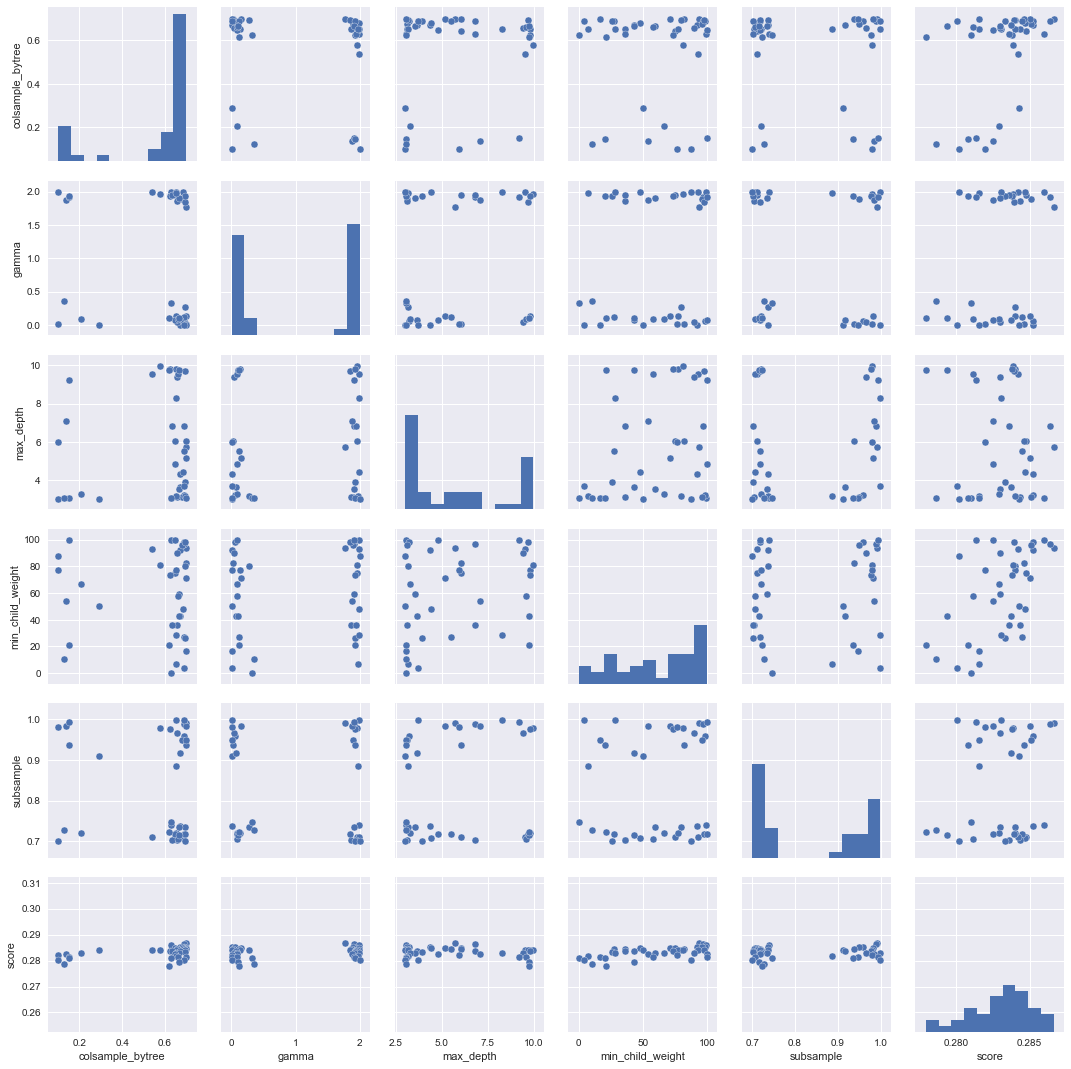

In [30]:
sns.pairplot(xgb_BO_scores)

### Train the model with smaller learning rate

In [31]:
xgb_params = xgb_BO_scores.iloc[0].to_dict()
xgb_params['objective'] = 'binary:logistic'
xgb_params['eta'] = 0.01  # Smaller

xgb_params['max_depth'] = int(xgb_params['max_depth'])
xgb_params['min_child_weight'] = int(xgb_params['min_child_weight'])
xgb_params['subsample'] = xgb_params['subsample']
xgb_params['colsample_bytree'] = xgb_params['colsample_bytree']
xgb_params['gamma'] = xgb_params['gamma']
xgb_params['seed'] = 1234

cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, maximize=True,
                    stratified=True,
                    #shuffle=True,
                    seed=1234,
                    early_stopping_rounds=10)

best_iteration = len(cv_results)
best_score = cv_results['test-gini-mean'].max()
print(best_score, best_iteration)

0.286112 171


In [32]:
model = xgb.train(xgb_params,
                  xgb.DMatrix(train_x, label=train_y.reshape(
                      train_x.shape[0], 1), missing=-1),
                  num_boost_round=best_xgb_iteration
                  )

preds = model.predict(xgb.DMatrix(test_x))

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("../output/sub_xgb_tuned.csv", index=False)

## 2.LightGBM

### Manual tuning
#### max_bin

In [33]:
%%time
scores = []
for max_bin in [100, 255, 400, 600, 800, 1000]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = max_bin

    print(max_bin)

    cv_results = lgb.cv(params,
                        lgb.Dataset(train_x, train_y, max_bin=max_bin),
                        num_boost_round=1000000,
                        nfold=5,
                        early_stopping_rounds=50,
                        feval=gini_lgb,
                        stratified=True,
                        shuffle=True,
                        verbose_eval=100
                        )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print(max_bin, best_iteration, best_score)
    scores.append([max_bin, best_iteration, best_score])

scores = pd.DataFrame(scores, columns=['max_bin', 'iteration', 'score'])
best_max_bin = scores.sort_values(by='score', ascending=False)[
    'max_bin'].values[0]
print('best max_bin is', best_max_bin)

100
[100]	cv_agg's gini: 0.273023 + 0.0125793
[200]	cv_agg's gini: 0.280231 + 0.011553
100 223 0.280466734018
255
[100]	cv_agg's gini: 0.272644 + 0.0134858
[200]	cv_agg's gini: 0.280776 + 0.0117713
255 170 0.28105984327
400
[100]	cv_agg's gini: 0.272948 + 0.0131354
[200]	cv_agg's gini: 0.279755 + 0.0115309
400 211 0.279909327712
600
[100]	cv_agg's gini: 0.272665 + 0.0134226
[200]	cv_agg's gini: 0.280374 + 0.0124065
600 172 0.280537864424
800
[100]	cv_agg's gini: 0.272488 + 0.0133795
[200]	cv_agg's gini: 0.280235 + 0.0118085
800 209 0.280443202942
1000
[100]	cv_agg's gini: 0.273059 + 0.0125486
[200]	cv_agg's gini: 0.280958 + 0.0115153
1000 182 0.281205631003
best max_bin is 1000
Wall time: 10min 59s


#### num_leaves

In [34]:
%%time
scores = []
for num_leaves in [3, 10, 30, 100, 300, 1000]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = num_leaves

    print(num_leaves)

    cv_results = lgb.cv(params,
                        lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                        num_boost_round=1000000,
                        nfold=5,
                        early_stopping_rounds=50,
                        feval=gini_lgb,
                        stratified=True,
                        shuffle=True,
                        verbose_eval=100
                        )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print(num_leaves, best_score, best_iteration)
    scores.append([num_leaves, best_iteration, best_score])

scores = pd.DataFrame(scores, columns=['num_leaves', 'iteration', 'score'])
best_num_leaves = scores.sort_values(by='score', ascending=False)[
    'num_leaves'].values[0]
print('best num_leaves is', best_num_leaves)

3
[100]	cv_agg's gini: 0.241533 + 0.0146355
[200]	cv_agg's gini: 0.260397 + 0.0145952
[300]	cv_agg's gini: 0.2669 + 0.0139285
[400]	cv_agg's gini: 0.270378 + 0.0132966
[500]	cv_agg's gini: 0.272701 + 0.0127816
[600]	cv_agg's gini: 0.274288 + 0.0124661
[700]	cv_agg's gini: 0.275392 + 0.0122985
[800]	cv_agg's gini: 0.276205 + 0.0123388
[900]	cv_agg's gini: 0.277022 + 0.0123529
[1000]	cv_agg's gini: 0.277688 + 0.0123589
[1100]	cv_agg's gini: 0.278188 + 0.0122068
[1200]	cv_agg's gini: 0.278631 + 0.0121955
[1300]	cv_agg's gini: 0.279064 + 0.0122255
[1400]	cv_agg's gini: 0.279355 + 0.0122246
[1500]	cv_agg's gini: 0.279544 + 0.0121935
[1600]	cv_agg's gini: 0.279736 + 0.0122782
[1700]	cv_agg's gini: 0.27981 + 0.0123666
[1800]	cv_agg's gini: 0.27997 + 0.0125068
[1900]	cv_agg's gini: 0.279978 + 0.0124685
3 0.280063234886 1869
10
[100]	cv_agg's gini: 0.265035 + 0.014386
[200]	cv_agg's gini: 0.277396 + 0.0125764
[300]	cv_agg's gini: 0.279675 + 0.0126527
[400]	cv_agg's gini: 0.280409 + 0.0123886
10

#### feature_fraction

In [35]:
%%time
scores = []
for feature_fraction in [0.2, 0.4, 0.6, 0.8]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = feature_fraction

    cv_results = lgb.cv(params,
                        lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                        num_boost_round=1000000,
                        nfold=5,
                        early_stopping_rounds=50,
                        feval=gini_lgb,
                        stratified=True,
                        shuffle=True,
                        verbose_eval=100
                        )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print(feature_fraction, best_iteration, best_score)
    scores.append([feature_fraction, best_iteration, best_score])

scores = pd.DataFrame(
    scores, columns=['feature_fraction', 'iteration', 'score'])
best_feature_fraction = scores.sort_values(by='score', ascending=False)[
    'feature_fraction'].values[0]
print('best feature_fraction is', best_feature_fraction)

[100]	cv_agg's gini: 0.268446 + 0.0141271
[200]	cv_agg's gini: 0.279326 + 0.0133914
[300]	cv_agg's gini: 0.280967 + 0.0123311
0.2 337 0.281317669424
[100]	cv_agg's gini: 0.273245 + 0.0142651
[200]	cv_agg's gini: 0.281696 + 0.0126985
0.4 220 0.282068209112
[100]	cv_agg's gini: 0.272742 + 0.0133852
[200]	cv_agg's gini: 0.281041 + 0.0115792
0.6 206 0.281190005209
[100]	cv_agg's gini: 0.272454 + 0.0132219
[200]	cv_agg's gini: 0.280137 + 0.0119044
0.8 235 0.280336164476
best feature_fraction is 0.4
Wall time: 8min 55s


#### bagging_fraction

In [36]:
%%time
scores = []
for bagging_fraction in [0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = best_feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1

    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print (bagging_fraction,best_iteration,best_score)
    scores.append([bagging_fraction,best_iteration,best_score])

scores = pd.DataFrame(scores, columns =['bagging_fraction','iteration','score'])
best_bagging_fraction = scores.sort_values(by='score',ascending=False)['bagging_fraction'].values[0]
print ('best bagging_fraction is', best_bagging_fraction)

[100]	cv_agg's gini: 0.268688 + 0.0142447
[200]	cv_agg's gini: 0.275493 + 0.0131868
0.3 203 0.275795494004
[100]	cv_agg's gini: 0.271492 + 0.0134166
[200]	cv_agg's gini: 0.279585 + 0.0114786
0.5 226 0.279976525151
[100]	cv_agg's gini: 0.272259 + 0.0142827
[200]	cv_agg's gini: 0.280916 + 0.0124876
0.7 204 0.281061361549
[100]	cv_agg's gini: 0.272651 + 0.0137161
[200]	cv_agg's gini: 0.281871 + 0.0121565
[300]	cv_agg's gini: 0.282266 + 0.0114071
0.9 288 0.282576360086
best bagging_fraction is 0.9
Wall time: 8min 10s


#### bagging_freq

In [37]:
%%time
scores = []
for bagging_freq in [1, 3, 5]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = best_feature_fraction
    params['bagging_fraction'] = best_bagging_fraction
    params['bagging_freq'] = bagging_freq

    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print (bagging_freq,best_iteration,best_score)
    scores.append([bagging_freq,best_iteration,best_score])

scores = pd.DataFrame(scores, columns =['bagging_freq','iteration','score'])
best_bagging_freq = scores.sort_values(by='score',ascending=False)['bagging_freq'].values[0]
print ('best bagging_freq is', best_bagging_freq)

[100]	cv_agg's gini: 0.272651 + 0.0137161
[200]	cv_agg's gini: 0.281871 + 0.0121565
[300]	cv_agg's gini: 0.282266 + 0.0114071
1 288 0.282576360086
[100]	cv_agg's gini: 0.272445 + 0.0137175
[200]	cv_agg's gini: 0.28128 + 0.0122658
3 242 0.282200440805
[100]	cv_agg's gini: 0.273077 + 0.0134944
[200]	cv_agg's gini: 0.28163 + 0.0121311
[300]	cv_agg's gini: 0.282152 + 0.0114117
5 301 0.282212367934
best bagging_freq is 1
Wall time: 7min 25s


#### min_gain_to_split

In [38]:
%%time
scores = []
for min_gain_to_split in [0, 0.1, 0.5, 1.0, 1.5]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = best_feature_fraction
    params['bagging_fraction'] = best_bagging_fraction
    params['min_gain_to_split'] = min_gain_to_split

    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print (min_gain_to_split,best_iteration,best_score)
    scores.append([min_gain_to_split,best_iteration,best_score])

scores = pd.DataFrame(scores, columns =['min_gain_to_split','iteration','score'])
best_min_gain_to_split = scores.sort_values(by='score',ascending=False)['min_gain_to_split'].values[0]
print ('best min_gain_to_split is', best_min_gain_to_split)



[100]	cv_agg's gini: 0.273245 + 0.0142651
[200]	cv_agg's gini: 0.281696 + 0.0126985
0 220 0.282068209112
[100]	cv_agg's gini: 0.273328 + 0.0144371
[200]	cv_agg's gini: 0.281919 + 0.0122338
0.1 249 0.282288287503
[100]	cv_agg's gini: 0.273527 + 0.0146882
[200]	cv_agg's gini: 0.28141 + 0.0129415
[300]	cv_agg's gini: 0.281188 + 0.0127019
0.5 270 0.281848470912
[100]	cv_agg's gini: 0.273074 + 0.0143032
[200]	cv_agg's gini: 0.280933 + 0.0124074
[300]	cv_agg's gini: 0.281432 + 0.0113348
1.0 280 0.281783698951
[100]	cv_agg's gini: 0.273305 + 0.0150123
[200]	cv_agg's gini: 0.280027 + 0.0128176
1.5 206 0.280084710983
best min_gain_to_split is 0.1
Wall time: 11min 3s


#### min_sum_hessian_in_leaf

In [39]:
%%time
scores = []
for min_sum_hessian_in_leaf in [0,0.001,1, 3, 10,30,100]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = best_feature_fraction
    params['bagging_fraction'] = best_bagging_fraction
    params['min_gain_to_split'] = best_min_gain_to_split
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf

    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print (min_sum_hessian_in_leaf,best_iteration,best_score)
    scores.append([min_sum_hessian_in_leaf,best_iteration,best_score])

scores = pd.DataFrame(scores, columns =['min_sum_hessian_in_leaf','iteration','score'])
best_min_sum_hessian_in_leaf = scores.sort_values(by='score',ascending=False)['min_sum_hessian_in_leaf'].values[0]
print ('best min_sum_hessian_in_leaf is', best_min_sum_hessian_in_leaf)

[100]	cv_agg's gini: 0.273328 + 0.0144371
[200]	cv_agg's gini: 0.281919 + 0.0122338
0 249 0.282288287503
[100]	cv_agg's gini: 0.273328 + 0.0144371
[200]	cv_agg's gini: 0.281919 + 0.0122338
0.001 249 0.282288287503
[100]	cv_agg's gini: 0.273191 + 0.0143871
[200]	cv_agg's gini: 0.282398 + 0.0122787
1 238 0.282875355805
[100]	cv_agg's gini: 0.273547 + 0.014546
[200]	cv_agg's gini: 0.282745 + 0.01206
3 212 0.283141588437
[100]	cv_agg's gini: 0.273898 + 0.0148723
[200]	cv_agg's gini: 0.283077 + 0.0131365
10 243 0.283392855766
[100]	cv_agg's gini: 0.27472 + 0.014328
[200]	cv_agg's gini: 0.283211 + 0.0121992
30 240 0.283818438944
[100]	cv_agg's gini: 0.275219 + 0.0142576
[200]	cv_agg's gini: 0.284883 + 0.0117436
[300]	cv_agg's gini: 0.285603 + 0.0113937
100 263 0.285830062817
best min_sum_hessian_in_leaf is 100.0
Wall time: 15min 39s


In [40]:
print (best_max_bin, best_num_leaves, best_feature_fraction, best_bagging_fraction, best_bagging_freq, 
       best_min_gain_to_split, best_min_sum_hessian_in_leaf)
       

1000 30 0.4 0.9 1 0.1 100.0


### Automated tuning

In [41]:
def lgb_evaluate(max_bin,
                 num_leaves,
                 min_sum_hessian_in_leaf,
                 min_gain_to_split,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2
                 ):
    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = int(max_bin)
    params['num_leaves'] = int(num_leaves)    
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split    
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = int(bagging_freq)


    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )

    return pd.DataFrame(cv_results)['gini-mean'].max()


lgb_BO = BayesianOptimization(lgb_evaluate, 
                             {'max_bin': (255, 255),
                              'num_leaves': (7, 31),
                              'min_sum_hessian_in_leaf': (1, 10),
                              'min_gain_to_split': (0,2),
                              'feature_fraction': (0.1, 0.3),
                              'bagging_fraction': (0.8,1),
                              'bagging_freq': (1,5),
                              'lambda_l1': (0,1),
                              'lambda_l2': (0,1)
                             }
                            )

lgb_BO.maximize(init_points=5, n_iter=50)



Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_bin |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 
[100]	cv_agg's gini: 0.266569 + 0.0143944
[200]	cv_agg's gini: 0.274199 + 0.0140008
[300]	cv_agg's gini: 0.277003 + 0.0133326
[400]	cv_agg's gini: 0.278108 + 0.0131144
[500]	cv_agg's gini: 0.278488 + 0.0131823
[600]	cv_agg's gini: 0.278721 + 0.0131547
    1 | 04m46s |    0.27873 |             0.8476 |         4.5900 |             0.1148 |      0.1514 |      0.6334 |  255.0000 |              1.7348 |                    8.5537 |      22.9840 | 
[100]	cv_agg's gini: 0.259921 + 0.0145383
[200]	cv_agg's gini: 0.273497 + 0.013451
[300]	cv_agg's gini: 0.277589 + 0.0129501
[400]	cv_agg's gini: 0.2

C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


    6 | 05m55s |    0.28260 |             0.9092 |         1.0721 |             0.2219 |      0.8931 |      0.1241 |  255.0000 |              0.0061 |                    9.0751 |       7.2364 | 
[100]	cv_agg's gini: 0.269519 + 0.0148098
[200]	cv_agg's gini: 0.280383 + 0.0132364
[300]	cv_agg's gini: 0.281505 + 0.0129412
[400]	cv_agg's gini: 0.281437 + 0.0122479
    7 | 03m12s |    0.28154 |             0.8580 |         1.1387 |             0.2335 |      0.7266 |      0.9335 |  255.0000 |              0.0057 |                    3.8907 |      29.9268 | 
[100]	cv_agg's gini: 0.267769 + 0.0141347
[200]	cv_agg's gini: 0.274425 + 0.0135676
[300]	cv_agg's gini: 0.278261 + 0.0129233
[400]	cv_agg's gini: 0.278693 + 0.0122582
    8 | 03m48s |    0.27924 |             0.8235 |         1.0685 |             0.1252 |      0.5096 |      0.0047 |  255.0000 |              0.0247 |                    1.8831 |      24.6397 | 
[100]	cv_agg's gini: 0.265235 + 0.0140738
[200]	cv_agg's gini: 0.274339 + 0.013

C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00018695]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   13 | 07m30s |    0.28222 |             0.9936 |         4.7637 |             0.2164 |      0.6262 |      0.0723 |  255.0000 |              0.1693 |                    5.9532 |       7.6256 | 
[100]	cv_agg's gini: 0.267493 + 0.0146749
[200]	cv_agg's gini: 0.279504 + 0.0133855
[300]	cv_agg's gini: 0.281702 + 0.0124601
[400]	cv_agg's gini: 0.282279 + 0.0119199


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.70208116e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


   14 | 03m27s |    0.28236 |             0.8696 |         3.5804 |             0.2983 |      0.7961 |      0.9769 |  255.0000 |              0.0248 |                    5.1345 |      15.1747 | 
[100]	cv_agg's gini: 0.265763 + 0.0145952
[200]	cv_agg's gini: 0.277697 + 0.0134463
[300]	cv_agg's gini: 0.280219 + 0.0127313
[400]	cv_agg's gini: 0.280676 + 0.012799


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.33846406e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   15 | 03m40s |    0.28068 |             0.9915 |         1.9997 |             0.2989 |      0.0084 |      0.0814 |  255.0000 |              1.6345 |                    9.5754 |      12.4341 | 
[100]	cv_agg's gini: 0.272374 + 0.0138011
[200]	cv_agg's gini: 0.281765 + 0.0123416


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010171]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -5.99644467e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   16 | 02m30s |    0.28227 |             0.9563 |         4.7863 |             0.2818 |      0.0510 |      0.7067 |  255.0000 |              0.0784 |                    9.8766 |      30.7849 | 
[100]	cv_agg's gini: 0.272244 + 0.0139759
[200]	cv_agg's gini: 0.280125 + 0.0128704
[300]	cv_agg's gini: 0.280615 + 0.012447
[400]	cv_agg's gini: 0.280649 + 0.0125052


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.33426724e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   17 | 03m16s |    0.28065 |             0.9895 |         1.2541 |             0.2969 |      0.1221 |      0.6871 |  255.0000 |              1.5210 |                    9.8885 |      30.9688 | 
[100]	cv_agg's gini: 0.271269 + 0.0139944
[200]	cv_agg's gini: 0.281088 + 0.0124227
[300]	cv_agg's gini: 0.282675 + 0.011704


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.19026183e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   18 | 03m01s |    0.28301 |             0.9243 |         1.0322 |             0.2948 |      0.0957 |      0.9184 |  255.0000 |              0.1639 |                    9.9634 |      26.2961 | 
[100]	cv_agg's gini: 0.268809 + 0.0146834
[200]	cv_agg's gini: 0.280924 + 0.0129936
[300]	cv_agg's gini: 0.28231 + 0.01243


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.69494888e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   19 | 02m58s |    0.28256 |             0.9800 |         4.9366 |             0.2717 |      0.1489 |      0.8593 |  255.0000 |              0.0159 |                    2.9870 |      19.6784 | 
[100]	cv_agg's gini: 0.267463 + 0.0145222
[200]	cv_agg's gini: 0.279988 + 0.0129194
[300]	cv_agg's gini: 0.282501 + 0.0119013
[400]	cv_agg's gini: 0.283008 + 0.0119131
[500]	cv_agg's gini: 0.283157 + 0.0114743
   20 | 04m00s |    0.28349 |             0.9823 |         3.6179 |             0.2750 |      0.1032 |      0.2210 |  255.0000 |              0.0293 |                    9.6281 |      15.7821 | 
[100]	cv_agg's gini: 0.261079 + 0.014819
[200]	cv_agg's gini: 0.2757 + 0.0132347
[300]	cv_agg's gini: 0.27954 + 0.0127421
[400]	cv_agg's gini: 0.281362 + 0.012411
[500]	cv_agg's gini: 0.28191 + 0.012367
[600]	cv_agg's gini: 0.282105 + 0.0125307
[700]	cv_agg's gini: 0.282442 + 0.0122449
   21 | 06m25s |    0.28258 |             0.9849 |         2.6115 |             0.2873 |      0.0376 |      0.193

C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0003501]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   28 | 03m22s |    0.28284 |             0.9776 |         4.1136 |             0.2982 |      0.0098 |      0.8495 |  255.0000 |              0.1165 |                    9.8023 |      21.1389 | 
[100]	cv_agg's gini: 0.270235 + 0.0145881
[200]	cv_agg's gini: 0.281301 + 0.0125035
[300]	cv_agg's gini: 0.282653 + 0.0121109
   29 | 02m46s |    0.28276 |             0.9263 |         1.1597 |             0.2181 |      0.6457 |      0.9723 |  255.0000 |              0.1844 |                    9.8461 |      30.9849 | 
[100]	cv_agg's gini: 0.268434 + 0.014644
[200]	cv_agg's gini: 0.28047 + 0.0133793
[300]	cv_agg's gini: 0.282297 + 0.0129434
[400]	cv_agg's gini: 0.283173 + 0.0122655
[500]	cv_agg's gini: 0.283117 + 0.0122312
   30 | 03m56s |    0.28335 |             0.9404 |         4.1366 |             0.2971 |      0.2391 |      0.0042 |  255.0000 |              0.0482 |                    6.4862 |      17.7014 | 
[100]	cv_agg's gini: 0.268528 + 0.0146209
[200]	cv_agg's gini: 0.280376 + 0.01268

C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00016966]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   32 | 06m00s |    0.28185 |             0.8454 |         4.7303 |             0.2945 |      0.0181 |      0.4714 |  255.0000 |              0.1282 |                    2.2078 |       7.5433 | 
[100]	cv_agg's gini: 0.268163 + 0.0145231
[200]	cv_agg's gini: 0.280228 + 0.0131251
[300]	cv_agg's gini: 0.282775 + 0.012424
   33 | 03m08s |    0.28296 |             0.8411 |         3.6753 |             0.2917 |      0.0096 |      0.1723 |  255.0000 |              0.0387 |                    8.1225 |      16.9453 | 
[100]	cv_agg's gini: 0.25726 + 0.0156464
[200]	cv_agg's gini: 0.27094 + 0.0143328
[300]	cv_agg's gini: 0.276514 + 0.0133899
[400]	cv_agg's gini: 0.27859 + 0.0130895
[500]	cv_agg's gini: 0.279883 + 0.0128614
[600]	cv_agg's gini: 0.280389 + 0.012781
[700]	cv_agg's gini: 0.280682 + 0.0127575
[800]	cv_agg's gini: 0.281125 + 0.0125596
[900]	cv_agg's gini: 0.281564 + 0.0120842
[1000]	cv_agg's gini: 0.281867 + 0.0118448
   34 | 07m49s |    0.28188 |             0.9838 |         1.0904 | 

C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00078646]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -4.07716616e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   36 | 02m48s |    0.28297 |             0.9999 |         3.4175 |             0.2963 |      0.8305 |      0.9059 |  255.0000 |              0.3491 |                    9.9974 |      26.2528 | 
[100]	cv_agg's gini: 0.269613 + 0.0142868
[200]	cv_agg's gini: 0.280752 + 0.0127774
[300]	cv_agg's gini: 0.28253 + 0.0117619
[400]	cv_agg's gini: 0.282668 + 0.011416
   37 | 03m22s |    0.28279 |             0.9743 |         1.1520 |             0.2907 |      0.9984 |      0.3864 |  255.0000 |              0.1088 |                    9.5966 |      19.8107 | 
[100]	cv_agg's gini: 0.25904 + 0.0148028
[200]	cv_agg's gini: 0.273414 + 0.0138369
[300]	cv_agg's gini: 0.277613 + 0.0130333
[400]	cv_agg's gini: 0.279394 + 0.012826
[500]	cv_agg's gini: 0.280263 + 0.012877
[600]	cv_agg's gini: 0.280617 + 0.0126617
[700]	cv_agg's gini: 0.280986 + 0.0126897


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.0012105]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   38 | 05m20s |    0.28100 |             0.9534 |         1.4713 |             0.2891 |      0.9989 |      0.0364 |  255.0000 |              0.1597 |                    1.6807 |       7.3574 | 
[100]	cv_agg's gini: 0.266272 + 0.0145688
[200]	cv_agg's gini: 0.278469 + 0.0134729
[300]	cv_agg's gini: 0.281142 + 0.0131245
[400]	cv_agg's gini: 0.28215 + 0.0129767
[500]	cv_agg's gini: 0.282744 + 0.0130414


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00107753]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00013226]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   39 | 04m24s |    0.28291 |             0.9461 |         4.3079 |             0.2988 |      0.0569 |      0.1753 |  255.0000 |              0.0218 |                    1.8728 |      13.1252 | 
[100]	cv_agg's gini: 0.267575 + 0.0143853
[200]	cv_agg's gini: 0.279526 + 0.0127376
[300]	cv_agg's gini: 0.281643 + 0.012664
[400]	cv_agg's gini: 0.281832 + 0.0126741
[500]	cv_agg's gini: 0.282171 + 0.0126804
   40 | 04m12s |    0.28229 |             0.9574 |         4.9296 |             0.2935 |      0.4903 |      0.0709 |  255.0000 |              0.0579 |                    3.6107 |      15.2202 | 
[100]	cv_agg's gini: 0.264048 + 0.0148501
[200]	cv_agg's gini: 0.27745 + 0.0136873
[300]	cv_agg's gini: 0.280399 + 0.0131458
[400]	cv_agg's gini: 0.281761 + 0.0131628
[500]	cv_agg's gini: 0.282362 + 0.0130362
[600]	cv_agg's gini: 0.28273 + 0.0130478
   41 | 04m49s |    0.28274 |             0.8743 |         1.2959 |             0.2860 |      0.8914 |      0.0997 |  255.0000 |              0.0401 | 

C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00154437]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   42 | 02m56s |    0.28146 |             0.9649 |         1.6041 |             0.2874 |      0.1311 |      0.9700 |  255.0000 |              0.1764 |                    1.0068 |      16.1221 | 
[100]	cv_agg's gini: 0.271319 + 0.0142154
[200]	cv_agg's gini: 0.278972 + 0.0126119
[300]	cv_agg's gini: 0.279401 + 0.0120061


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00153231]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   43 | 02m42s |    0.27956 |             0.9176 |         1.3576 |             0.2912 |      0.8049 |      0.9573 |  255.0000 |              1.9709 |                    1.4024 |      30.8173 | 
[100]	cv_agg's gini: 0.270793 + 0.014147
[200]	cv_agg's gini: 0.28126 + 0.0122073


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00016707]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   44 | 02m36s |    0.28226 |             0.9932 |         4.9215 |             0.2837 |      0.1054 |      0.6045 |  255.0000 |              0.0681 |                    5.5381 |      26.4809 | 
[100]	cv_agg's gini: 0.260043 + 0.0145075
[200]	cv_agg's gini: 0.273544 + 0.0135229
[300]	cv_agg's gini: 0.27771 + 0.0125648
[400]	cv_agg's gini: 0.279978 + 0.0125647
[500]	cv_agg's gini: 0.281413 + 0.0128529
[600]	cv_agg's gini: 0.282451 + 0.0127063


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0008785]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -8.88798386e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   45 | 04m49s |    0.28247 |             0.8290 |         4.6596 |             0.2971 |      0.3347 |      0.3500 |  255.0000 |              0.0149 |                    7.7316 |       7.1354 | 
[100]	cv_agg's gini: 0.2624 + 0.0147829
[200]	cv_agg's gini: 0.276034 + 0.0134284
[300]	cv_agg's gini: 0.279713 + 0.0132166
[400]	cv_agg's gini: 0.280831 + 0.0126571
[500]	cv_agg's gini: 0.281455 + 0.0124406


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00027756]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


   46 | 04m30s |    0.28186 |             0.9659 |         4.8463 |             0.2993 |      0.1629 |      0.8322 |  255.0000 |              0.0048 |                    3.2891 |       9.6470 | 
[100]	cv_agg's gini: 0.270906 + 0.0138041
[200]	cv_agg's gini: 0.281414 + 0.0127018
[300]	cv_agg's gini: 0.282487 + 0.0119535
   47 | 03m06s |    0.28267 |             0.9907 |         3.1282 |             0.2904 |      0.9252 |      0.8912 |  255.0000 |              0.0797 |                    4.7277 |      24.2400 | 
[100]	cv_agg's gini: 0.267818 + 0.0145628
[200]	cv_agg's gini: 0.280162 + 0.013006
[300]	cv_agg's gini: 0.282015 + 0.0129233
[400]	cv_agg's gini: 0.282599 + 0.0127188
   48 | 03m45s |    0.28272 |             0.9766 |         4.9981 |             0.2897 |      0.0498 |      0.9438 |  255.0000 |              0.0799 |                    7.7741 |      15.7502 | 
[100]	cv_agg's gini: 0.271361 + 0.0139465
[200]	cv_agg's gini: 0.280796 + 0.0121461
[300]	cv_agg's gini: 0.28153 + 0.01182

C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00699137]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   49 | 02m46s |    0.28173 |             0.9611 |         4.6146 |             0.2855 |      0.1918 |      0.9614 |  255.0000 |              0.1301 |                    1.1803 |      26.7600 | 
[100]	cv_agg's gini: 0.25837 + 0.014737
[200]	cv_agg's gini: 0.272831 + 0.0136612
[300]	cv_agg's gini: 0.277039 + 0.0129936
[400]	cv_agg's gini: 0.278844 + 0.0127929
[500]	cv_agg's gini: 0.279747 + 0.0126245
[600]	cv_agg's gini: 0.280251 + 0.0125575
[700]	cv_agg's gini: 0.280406 + 0.0124568
[800]	cv_agg's gini: 0.280504 + 0.0124656
   50 | 06m12s |    0.28050 |             0.9441 |         1.3817 |             0.2596 |      0.4288 |      0.8677 |  255.0000 |              1.3898 |                    9.9993 |       7.0185 | 
[100]	cv_agg's gini: 0.271085 + 0.0140462
[200]	cv_agg's gini: 0.282062 + 0.0129041
[300]	cv_agg's gini: 0.283122 + 0.0123537


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00461813]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   51 | 02m45s |    0.28357 |             0.9328 |         2.9713 |             0.2831 |      0.3714 |      0.1145 |  255.0000 |              0.0484 |                    9.9460 |      24.5029 | 
[100]	cv_agg's gini: 0.270763 + 0.0144907
[200]	cv_agg's gini: 0.280773 + 0.0131204
[300]	cv_agg's gini: 0.282669 + 0.0126331
   52 | 03m12s |    0.28291 |             0.9726 |         1.3948 |             0.2744 |      0.9319 |      0.1548 |  255.0000 |              0.2354 |                    9.9022 |      24.2880 | 
[100]	cv_agg's gini: 0.269696 + 0.0139933
[200]	cv_agg's gini: 0.280601 + 0.0123394
[300]	cv_agg's gini: 0.281693 + 0.0122957


C:\Users\Zhisheng\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01255099]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   53 | 03m04s |    0.28176 |             0.9796 |         4.3525 |             0.2767 |      0.0574 |      0.0686 |  255.0000 |              0.1190 |                    3.5972 |      21.8506 | 
[100]	cv_agg's gini: 0.258492 + 0.0151019
[200]	cv_agg's gini: 0.271244 + 0.0141091
[300]	cv_agg's gini: 0.276382 + 0.0133817
[400]	cv_agg's gini: 0.278521 + 0.0131242
[500]	cv_agg's gini: 0.279441 + 0.0130275
[600]	cv_agg's gini: 0.279901 + 0.0125767
[700]	cv_agg's gini: 0.280451 + 0.0125684
   54 | 05m32s |    0.28053 |             0.8482 |         1.1368 |             0.1845 |      0.0154 |      0.0983 |  255.0000 |              0.2481 |                    6.7239 |       7.0898 | 
[100]	cv_agg's gini: 0.270626 + 0.0143309
[200]	cv_agg's gini: 0.281461 + 0.0127715
[300]	cv_agg's gini: 0.283153 + 0.0118337
   55 | 03m08s |    0.28334 |             0.9939 |         4.9017 |             0.2537 |      0.0650 |      0.7222 |  255.0000 |              0.0421 |                    9.8967 |      25.772

#### Show LightGBM tuning results

In [42]:
lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)
lgb_BO_scores

,bagging_fraction,bagging_freq,feature_fraction,lambda_l1,lambda_l2,max_bin,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
45,0.932793,2.971340,0.283091,0.371445,0.114529,255.0,0.048368,9.946037,24.502922,0.283572
14,0.982331,3.617896,0.274973,0.103242,0.221000,255.0,0.029334,9.628064,15.782107,0.283493
24,0.940444,4.136577,0.297076,0.239058,0.004210,255.0,0.048181,6.486177,17.701362,0.283346
49,0.993867,4.901687,0.253720,0.065042,0.722195,255.0,0.042066,9.896654,25.772860,0.283344
25,0.969060,4.998956,0.269117,0.115029,0.079544,255.0,0.044776,9.182740,17.220908,0.283294
19,0.855095,4.988563,0.292743,0.064472,0.152085,255.0,0.063522,7.707166,13.117873,0.283279
18,0.807684,4.937171,0.295638,0.904179,0.018327,255.0,0.010013,9.744604,17.939564,0.283073
12,0.924344,1.032222,0.294768,0.095708,0.918402,255.0,0.163941,9.963363,26.296097,0.283013
30,0.999901,3.417539,0.296348,0.830465,0.905924,255.0,0.349108,9.997369,26.252827,0.282966
27,0.841082,3.675332,0.291673,0.009564,0.172308,255.0,0.038699,8.122472,16.945317,0.282955


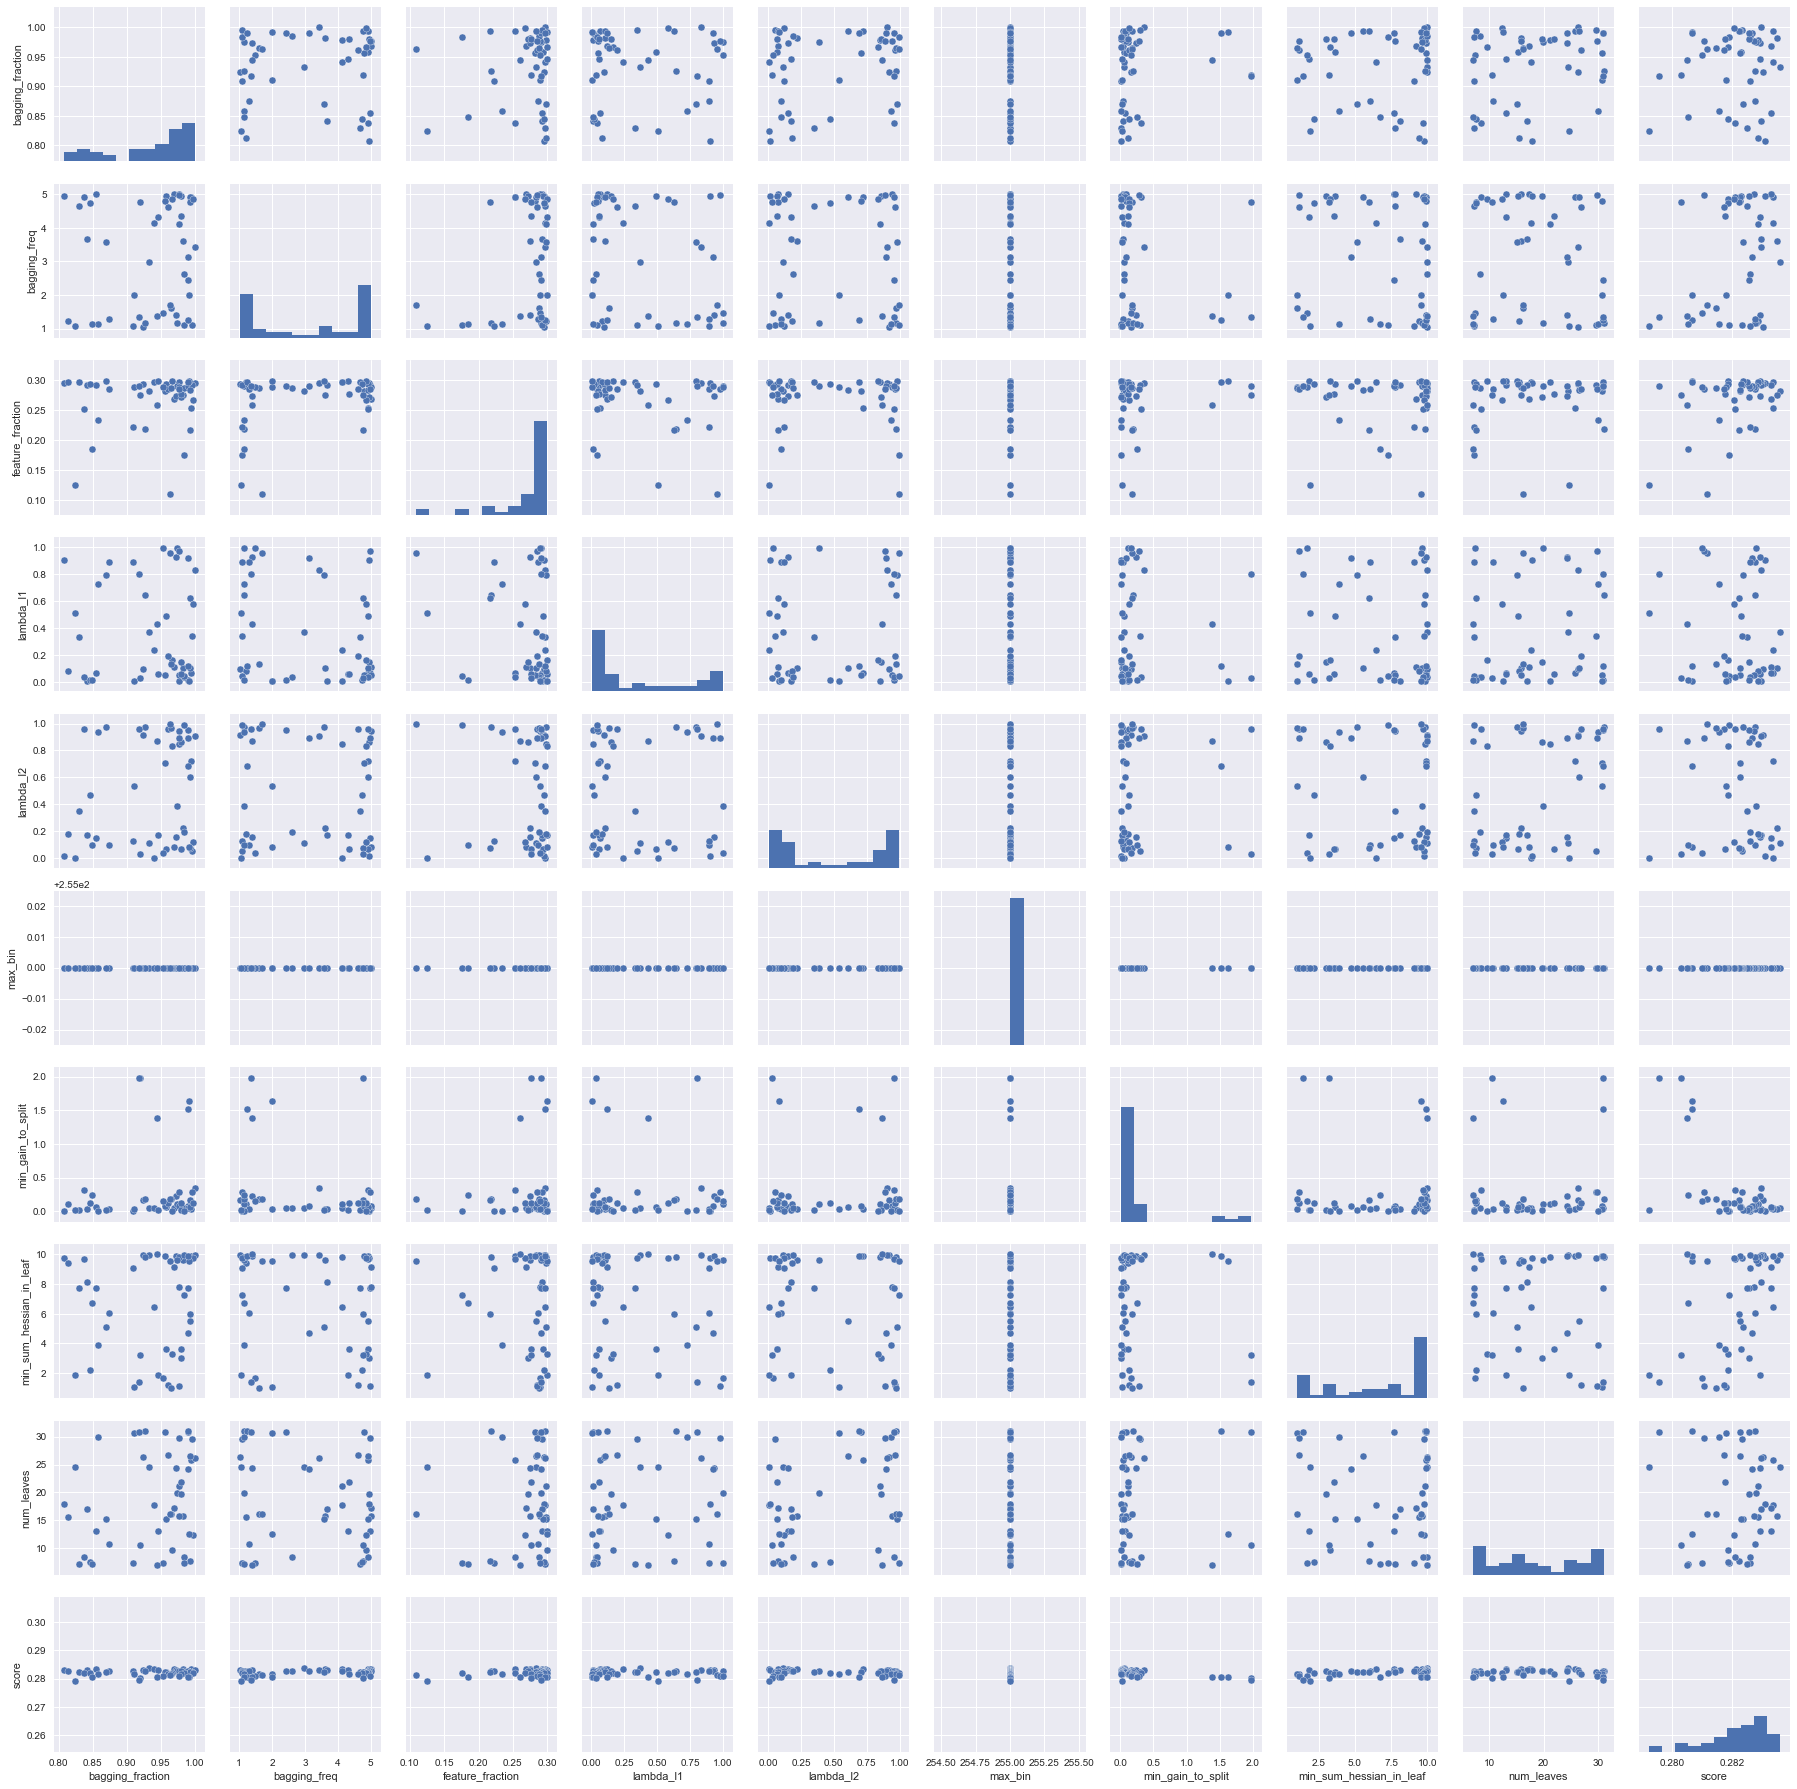

In [43]:
sns.pairplot(lgb_BO_scores)

#### Train the model with smaller learning rate

In [44]:
params = lgb_BO_scores.iloc[0].to_dict()
lgb_params = dict()
lgb_params['objective'] = 'binary'
lgb_params['learning_rate'] = 0.01 # Smaller learning rate


lgb_params['max_bin'] = int(params['max_bin'])   
lgb_params['num_leaves'] = int(params['num_leaves'])    
lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
lgb_params['feature_fraction'] = params['feature_fraction']
lgb_params['bagging_fraction'] = params['bagging_fraction']
lgb_params['bagging_freq'] = 1


cv_results = lgb.cv(lgb_params,
                lgb.Dataset(train_x, train_y, max_bin=lgb_params['max_bin']),
                num_boost_round=1000000,
                nfold=5,
                early_stopping_rounds=200,
                feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                verbose_eval=100
               )

cv_results = pd.DataFrame(cv_results)
best_lgb_iteration = len(cv_results)
best_lgb_score = cv_results['gini-mean'].max()

print (best_lgb_iteration, best_lgb_score)





[100]	cv_agg's gini: 0.258601 + 0.0139727
[200]	cv_agg's gini: 0.262078 + 0.0146871
[300]	cv_agg's gini: 0.265881 + 0.0145287
[400]	cv_agg's gini: 0.269924 + 0.014683
[500]	cv_agg's gini: 0.273712 + 0.0144437
[600]	cv_agg's gini: 0.276703 + 0.0139143
[700]	cv_agg's gini: 0.278874 + 0.0135779
[800]	cv_agg's gini: 0.28074 + 0.0132742
[900]	cv_agg's gini: 0.282284 + 0.0130473
[1000]	cv_agg's gini: 0.28315 + 0.0128397
[1100]	cv_agg's gini: 0.283836 + 0.0126157
[1200]	cv_agg's gini: 0.284408 + 0.0125345
[1300]	cv_agg's gini: 0.28472 + 0.012453
[1400]	cv_agg's gini: 0.284888 + 0.0122637
[1500]	cv_agg's gini: 0.285054 + 0.0121546
[1600]	cv_agg's gini: 0.285186 + 0.0120645
[1700]	cv_agg's gini: 0.285216 + 0.0119867
[1800]	cv_agg's gini: 0.285196 + 0.011902
[1900]	cv_agg's gini: 0.285121 + 0.011841
1755 0.285265796829


In [45]:
model = lgb.train(lgb_params,
                  lgb.Dataset(train_x, max_bin=lgb_params['max_bin']),
                  num_boost_round=best_lgb_iteration
                  )

preds = model.predict(test_x)

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("../output/sub_lgb_tuned.csv", index=False)

## Model stacking

1. We'll leverage the tuned parameter sets to train 5 XGBoost models and 5 LightGBM models for level 1.
2. The outputs of level models will contain 3(classes)*10(models) = 15 features. 
3. We'll train a MLP model using these 15 features only
4. We'll train another LightGBM using these 15 features plus original features
5. The outputs from the two level 2 models can be combined as the final submission

In [ ]:
model_selection

In [46]:
def blend_xgb_model(params_list, train_x, train_y, test_x, 
                    num_class, blend_folds,kf_random_state=1234, missing=None, 
                    stratified=False, shuffle=False  ):
    if stratified:
        skf = model_selection.StratifiedKFold(n_splits=blend_folds,random_state=kf_random_state, shuffle=shuffle)
    else:
        skf = model_selection.KFold(n_splits=blend_folds,random_state=kf_random_state, shuffle=shuffle)
    skf_ids = list(skf.split(train_x, train_y))


    train_blend_x = np.zeros((train_x.shape[0], len(params_list)))
    test_blend_x = np.zeros((test_x.shape[0], len(params_list)))
    blend_scores = np.zeros ((blend_folds,len(params_list)))

    print  ("Start blending.")
    for j, params in enumerate(params_list):
        print ("Blending model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            params['seed'] = random.randint(1, 65535)
            start = time.time()
            print ("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            # Set n_estimators to a large number for early_stopping   
            print (params, params['num_boost_round'], missing)
            model = xgb.train(params,
                                xgb.DMatrix(train_x_fold, 
                                            label=train_y_fold.reshape(train_y_fold.shape[0],1), 
                                            missing=missing),
                                num_boost_round=params['num_boost_round']
                            )
            val_y_predict_fold = model.predict(xgb.DMatrix(val_x_fold,missing=missing),
                                              )
            
            score = gini_normalized(val_y_fold,val_y_predict_fold)
            print ("gini: ", score)
            blend_scores[i,j]=score
            train_blend_x[val_ids, j] = val_y_predict_fold
            test_blend_x_j = test_blend_x_j + model.predict(xgb.DMatrix(test_x,missing=missing))
            print (time.time()-start)
        test_blend_x[:,j] = test_blend_x_j/blend_folds
        print ("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores    


def blend_lgb_model(params_list, train_x, train_y, test_x, 
                    num_class, blend_folds,kf_random_state=1234, missing=None, 
                    stratified=False, shuffle=False  ):

    if stratified:
        skf = model_selection.StratifiedKFold(n_splits=blend_folds,random_state=kf_random_state, shuffle=shuffle)
    else:
        skf = model_selection.KFold(n_splits=blend_folds,random_state=kf_random_state, shuffle=shuffle)
    skf_ids = list(skf.split(train_x, train_y))

    train_blend_x = np.zeros((train_x.shape[0], len(params_list)))
    test_blend_x = np.zeros((test_x.shape[0], len(params_list)))
    blend_scores = np.zeros ((blend_folds,len(params_list)))

    print  ("Start blending.")
    for j, p in enumerate(params_list):
        params = p
        max_bin = params['max_bin']
        num_boost_round=params['num_boost_round']
        print ("Blending model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            params['seed'] = random.randint(1, 65535)
            start = time.time()
            print ("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            # Set n_estimators to a large number for early_stopping          
            model = lgb.train(params,
                                lgb.Dataset(train_x_fold, train_y_fold, max_bin=max_bin),
                                num_boost_round=num_boost_round
                            )
            val_y_predict_fold = model.predict(val_x_fold)
            print (val_y_predict_fold.shape)
            score = gini_normalized(val_y_fold,val_y_predict_fold)
            print ("gini: ", score)
            blend_scores[i,j]=score
            train_blend_x[val_ids, j] = val_y_predict_fold
            test_blend_x_j = test_blend_x_j + model.predict(test_x)
            print (time.time()-start)
        test_blend_x[:,j] = test_blend_x_j/blend_folds
        print ("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores   




In [47]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = model_selection.GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = 'log_loss',
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [48]:
lgb_param_list = []

for p in lgb_BO_scores.head(5).iterrows(): #Top 5 sets of params
    params = dict()
    params['objective'] = 'binary'
#     params['num_class'] = 3
    params['learning_rate'] = 0.01
    params['max_bin'] = int(p[1].to_dict()['max_bin'])
    params['num_leaves'] = int(p[1].to_dict()['num_leaves'])   
    params['min_sum_hessian_in_leaf'] = int(p[1].to_dict()['min_sum_hessian_in_leaf'])   
    params['min_gain_to_split'] = p[1].to_dict()['min_gain_to_split']    
    params['feature_fraction'] = p[1].to_dict()['feature_fraction']
    params['bagging_fraction'] = p[1].to_dict()['bagging_fraction']
    params['bagging_freq'] = int(p[1].to_dict()['bagging_freq'])
    params['num_boost_round'] = best_lgb_iteration
    print (params)
    lgb_param_list.append(params) 

{'objective': 'binary', 'learning_rate': 0.01, 'max_bin': 255, 'num_leaves': 24, 'min_sum_hessian_in_leaf': 9, 'min_gain_to_split': 0.048368072694843889, 'feature_fraction': 0.28309120802777921, 'bagging_fraction': 0.93279323158466376, 'bagging_freq': 2, 'num_boost_round': 1755}
{'objective': 'binary', 'learning_rate': 0.01, 'max_bin': 255, 'num_leaves': 15, 'min_sum_hessian_in_leaf': 9, 'min_gain_to_split': 0.02933374498275243, 'feature_fraction': 0.2749730876167622, 'bagging_fraction': 0.98233114289856993, 'bagging_freq': 3, 'num_boost_round': 1755}
{'objective': 'binary', 'learning_rate': 0.01, 'max_bin': 255, 'num_leaves': 17, 'min_sum_hessian_in_leaf': 6, 'min_gain_to_split': 0.048181342419311601, 'feature_fraction': 0.29707585161585509, 'bagging_fraction': 0.94044374149725196, 'bagging_freq': 4, 'num_boost_round': 1755}
{'objective': 'binary', 'learning_rate': 0.01, 'max_bin': 255, 'num_leaves': 25, 'min_sum_hessian_in_leaf': 9, 'min_gain_to_split': 0.042065848063132627, 'feature

In [49]:

xgb_param_list = []

for p in xgb_BO_scores[:5].iterrows():
    start = time.time()
    params = dict()
    params['objective'] = 'binary:logistic'
    params['num_boost_round'] = best_xgb_iteration
    params['eta'] = 0.01
    params['max_depth'] = int(p[1].to_dict()['max_depth'])
    params['min_child_weight'] = int(p[1].to_dict()['min_child_weight'])
    params['subsample'] = p[1].to_dict()['subsample']
    params['colsample_bytree'] = p[1].to_dict()['colsample_bytree']
    params['gamma'] = p[1].to_dict()['gamma']
    params['seed']=1234
    xgb_param_list.append(params)

print(xgb_param_list)

[{'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 93, 'subsample': 0.99147948387028806, 'colsample_bytree': 0.6970300476283684, 'gamma': 1.7628259028468038, 'seed': 1234}, {'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 96, 'subsample': 0.98829489686094096, 'colsample_bytree': 0.68731482004312394, 'gamma': 1.9168359103211263, 'seed': 1234}, {'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 99, 'subsample': 0.73964450667316739, 'colsample_bytree': 0.62969761003768299, 'gamma': 1.9925414203329015, 'seed': 1234}, {'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 91, 'subsample': 0.73737324467736198, 'colsample_bytree': 0.67108125586239731, 'gamma': 0.0029753008014667959, 'seed': 1234}, {'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth'

In [50]:
train_blend_x_lgb_01, test_blend_x_lgb_01, blend_scores_lgb_01 = blend_lgb_model(lgb_param_list,
                                                                                         train_x,
                                                                                         train_y,
                                                                                         test_x,
                                                                                         num_class=2,
                                                                                         blend_folds=5,
                                                                                         stratified=True,
                                                                                        shuffle=True,
                                                                                        )

np.savetxt('../input/train_blend_x_lgb_01.csv',train_blend_x_lgb_01, delimiter=',')
np.savetxt('../input/test_blend_x_lgb_01.csv',test_blend_x_lgb_01, delimiter=',')

Start blending.
Blending model 1 {'objective': 'binary', 'learning_rate': 0.01, 'max_bin': 255, 'num_leaves': 24, 'min_sum_hessian_in_leaf': 9, 'min_gain_to_split': 0.048368072694843889, 'feature_fraction': 0.28309120802777921, 'bagging_fraction': 0.93279323158466376, 'bagging_freq': 2, 'num_boost_round': 1755}
Model 1 fold 1


C:\Users\Zhisheng\Anaconda3\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(119043,)
gini:  0.284103065357
67.88622617721558
Model 1 fold 2
(119043,)
gini:  0.294876959133
66.79659986495972
Model 1 fold 3
(119043,)
gini:  0.287382968609
65.18854904174805
Model 1 fold 4
(119042,)
gini:  0.282972572208
65.99918699264526
Model 1 fold 5
(119041,)
gini:  0.283004958459
65.54739236831665
Score for model 1 is 0.286468
Blending model 2 {'objective': 'binary', 'learning_rate': 0.01, 'max_bin': 255, 'num_leaves': 15, 'min_sum_hessian_in_leaf': 9, 'min_gain_to_split': 0.02933374498275243, 'feature_fraction': 0.2749730876167622, 'bagging_fraction': 0.98233114289856993, 'bagging_freq': 3, 'num_boost_round': 1755}
Model 2 fold 1
(119043,)
gini:  0.283108242477
57.12427520751953
Model 2 fold 2
(119043,)
gini:  0.294883368609
55.140280961990356
Model 2 fold 3
(119043,)
gini:  0.286358838956
56.2668297290802
Model 2 fold 4
(119042,)
gini:  0.281503182191
57.390474796295166
Model 2 fold 5
(119041,)
gini:  0.280366782202
57.9491708278656
Score for model 2 is 0.285244
Blending m

In [51]:
train_blend_x_xgb_01, test_blend_x_xgb_01, blend_scores_xgb_01 = blend_xgb_model(xgb_param_list,
                                                                                         train_x,
                                                                                         train_y,
                                                                                         test_x,
                                                                                         num_class=2,
                                                                                         blend_folds=5,
                                                                                         stratified=True,
                                                                                        shuffle=True,
                                                                                        )


np.savetxt('../input/train_blend_x_xgb_01.csv',train_blend_x_xgb_01, delimiter=',')
np.savetxt('../input/test_blend_x_xgb_01.csv',test_blend_x_xgb_01, delimiter=',')

Start blending.
Blending model 1 {'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 93, 'subsample': 0.99147948387028806, 'colsample_bytree': 0.6970300476283684, 'gamma': 1.7628259028468038, 'seed': 1234}
Model 1 fold 1
{'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 93, 'subsample': 0.99147948387028806, 'colsample_bytree': 0.6970300476283684, 'gamma': 1.7628259028468038, 'seed': 54811} 116 None
gini:  0.241180767099
45.194344997406006
Model 1 fold 2
{'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 93, 'subsample': 0.99147948387028806, 'colsample_bytree': 0.6970300476283684, 'gamma': 1.7628259028468038, 'seed': 23315} 116 None
gini:  0.26508170807
43.972023010253906
Model 1 fold 3
{'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 93, 'subsample': 0.991479483870288

gini:  0.225868914758
27.62761664390564
Model 5 fold 5
{'objective': 'binary:logistic', 'num_boost_round': 116, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 98, 'subsample': 0.95963924850362714, 'colsample_bytree': 0.6886539158247732, 'gamma': 0.058178600764881461, 'seed': 22015} 116 None
gini:  0.22740260656
27.515881299972534
Score for model 5 is 0.231325


### Level 1 LightGBM + XGBoost -> Level 2 Logistic Regression

Here we are training a Logistic Regression model with features generated Level 1 models. 

In [52]:

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}
model = search_model(np.hstack([train_blend_x_lgb_01, train_blend_x_xgb_01])
                     train_y, LogisticRegression(), param_grid, n_jobs=1, cv=4, refit=True)

SyntaxError: invalid syntax (<ipython-input-52-52109667cb0c>, line 6)

In [ ]:
preds_lr = model.predict_proba(np.hstack([test_blend_x_lgb_01, test_blend_x_xgb_01]))

sub_df = pd.DataFrame({'id': ids, 'target': preds_lr[:,1]})
sub_df.to_csv("../output/sub_l1lgb_xgb_l2lr.csv", index=False)

### Level 1 LightGBM features + original features -> Level 2 LightGBM

Here we are training a LightGBM model with features generated by Level 1 models, PLUS original features.

In [ ]:
params = lgb_BO_scores.iloc[0].to_dict()
lgb_params = dict()
lgb_params['objective'] = 'binary'
lgb_params['learning_rate'] = 0.01 # Smaller learning rate


lgb_params['max_bin'] = int(params['max_bin'])   
lgb_params['num_leaves'] = int(params['num_leaves'])    
lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
lgb_params['feature_fraction'] = params['feature_fraction']
lgb_params['bagging_fraction'] = params['bagging_fraction']
lgb_params['bagging_freq'] = 1


cv_results = lgb.cv(lgb_params,
                lgb.Dataset(np.hstack((train_x,train_blend_x_lgb_01, train_blend_x_xgb_01)), train_y, max_bin=lgb_params['max_bin']),
                num_boost_round=1000000,
                nfold=5,
                early_stopping_rounds=200,
                feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                verbose_eval=100
               )

cv_results = pd.DataFrame(cv_results)
best_lgb_iteration_stack = len(cv_results)
best_lgb_score_stack = cv_results['gini-mean'].max()

print (best_lgb_iteration_stack, best_lgb_score_stack)


In [ ]:
model = lgb.train(lgb_params,
                  lgb.Dataset(train_x, max_bin=lgb_params['max_bin']),
                  num_boost_round=best_lgb_iteration
                  )

preds_lgb = model.predict(np.hstack((test_x,test_blend_x_lgb_01, test_blend_x_xgb_01)))

sub_df = pd.DataFrame({'id': ids, 'target': preds_lgb})
sub_df.to_csv("../output/sub_l1lgb_xgb_l2lgb.csv", index=False)

#### Final ensemble

In [ ]:
preds = (preds_lr + preds_lgb)/2

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("../output/sub_l1lgb_xgb_l2lrlgb.csv", index=False)

# Conclusion

In this week we've learnt how to create model ensemble, particularly with model stacking scheme. Keep in mind that the key considerations for building a good ensemble solution are diversity and randomness which can be introduced by:

* Deploying heterogeneous algorithms
* Using modified version of training data
* Randomizing learning algorithms with different parameters


# Addtional readings

* [Kaggle Ensembling Guide by MLWave](http://mlwave.com/kaggle-ensembling-guide/)
* [Deep Forest: Towards An Alternative to Deep Neural Networks by Zhihua Zhou](https://arxiv.org/abs/1702.08835)
* StackNet by Kaz-Anova
    * https://github.com/kaz-Anova/StackNet
    * https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/30012